In [19]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Optimizing Orbital Eccentricity Using Newton's Method & Gradient Descent 

## **1. Introduction**

In this project, we explore how two numerical optimization methods:

- **Newton's Method for solving nonlinear equations**, and 
- **Multi-Dimensional Gradient Descent**

can be used to analyze and optimize an orbital system.

The orbit simulation itsself is **not** the numerical being analyzed.
Instead, it serves as the *environment* whose behavior we want to optimize.

Our goal is:

> **Find the initial velocity vector that produces the most circular orbit by minimizing orbital eccentricity.**

We will:
- Use **Newton's Method** to compute the *exact circular-orbit velocity*.
- Use **Gradient Descent** to *optimize* a general initial velocity toward a circular orbit. 

## **2.Physics Background**


### **2.1 Two-Body Orbital Motion**
We assume classical Newtonian gravity:

$$
\ddot{\mathbf{r}} = -\frac{\mu}{r^3}\mathbf{r}
$$

where
- $\mathbf{r} = (x, y)$ is the position vector
- $\mu = GM$ is the standard gravitational parameter
- $r = \|\mathbf{r}\|$

### **2.2 Circular Orbit Condition**

A circular orbit at radius $r$ requires:

$$
v_{\text{circ}} = \sqrt{\frac{\mu}{r}}
$$

This can be written as the nonlinear equation:

$$
F(v) = v^2 - \frac{\mu}{r} = 0
$$

We will solve this using Newton's Method.

### **2.3 Orbital Eccentricity**

We define eccentricity $e$ using:

$$
e =
\sqrt{
1 +
\frac{2 E h^2}{\mu^2}
}
$$

Where:

- $E = \frac{v^2}{2} - \frac{\mu}{r}$ is specific mechanical energy
- $h = |x v_y - y v_x|$ is specific angular momentum

We minimize: 

$$
C(v_x, v_y) = e(v_x, v_y)^2
$$

## **3. Method 1 - Newton's Method for Nonlinear Equations**

Newton's Iteration rule:

$$
v_{k+1}
= v_k - \frac{F(v_k)}{F'(v_k)}
$$

Where:

$$
F(v) = v^2 - \frac{\mu}{r},
\qquad
F'(v) = 2v. 
$$

### **3.1 Define F(v) and F'(v)**

In [5]:
# Constants for a satellite orbiting Earth
mu = 398600.0  # Earth's gravitational parameter, km^3/s^2
r0 = 6771.0    # Initial orbital radius, km

# Nonlinear function F(v) = v^2 - mu/r
def F(v):
    return v**2 - mu / r0

# Derivative F'(v) = 2v
def dF(v):
    return 2 * v

### **3.2 Newton's Method Solver**

In [6]:
def newton_method(v0, max_iter=100, tol=1e-8):
    v = v0
    v_values = [v]
    errors = [abs(F(v))]

    for i in range(max_iter):
        if abs(F(v)) < tol:
            break
        
        v = v - F(v) / dF(v)

        v_values.append(v)
        errors.append(abs(F(v)))

    return np.array(v_values), np.array(errors)

# Example run with a initial guess
v_values, errors = newton_method(v0=5.0)

print("Approximate solution for orbital velocity:", v_values[-1], "km/s")

Approximate solution for orbital velocity: 7.672594396548674 km/s


### **3.3 Plot convergence**

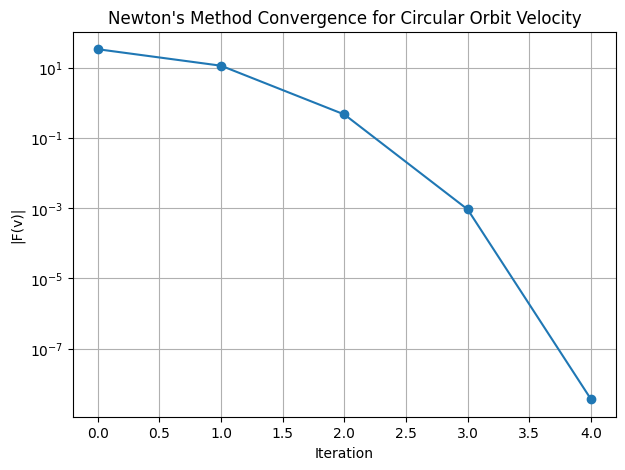

In [7]:
plt.figure(figsize=(7,5))
plt.semilogy(errors, marker='o')
plt.xlabel('Iteration')
plt.ylabel('|F(v)|')
plt.title("Newton's Method Convergence for Circular Orbit Velocity")
plt.grid(True)
plt.show()

You can see that the residual $|F(v)|$ dropped from $10^1$ to below $10^{-7}$ in just 4 iterations.

## **4. Orbit Simulator (Support Method)**

This is **not** a numerical method for the project - just a simulation tool.

### **4.1 Gravity Acceleration**

For a satellite at position:

$$
\mathbf{r} = (x, y)
$$

the gravitational acceleration from Earth is:

$$
\mathbf{a} = -\frac{\mu}{r^3}\,\mathbf{r}
$$

Where:

- $\mu = 398600\ \text{km}^3/\text{s}^2$ is Earth’s gravitational parameter  
- $r = \sqrt{x^2 + y^2}$ is the distance from Earth’s center  

The acceleration components are:

$$
a_x = -\frac{\mu}{r^3}\,x
$$

$$
a_y = -\frac{\mu}{r^3}\,y
$$

This is the core of any 2D orbit simulation.


In [8]:
""" 
Compute gravitational acceleration from Earth at position (x, y)
Inputs: x, y: position coordinates in km
Outputs: ax, ay: acceleration components in km/s^2
"""
def gravity_acceleration(x, y):

    r = np.sqrt(x**2 + y**2)
    ax = -mu * x / r**3
    ay = -mu * y / r**3
    return ax, ay

ax, ay = gravity_acceleration(6771.0, 0.0)
print(ax, ay)

-0.008694240846306914 -0.0


### **4.2 Integrator Step (Euler Method)**

To simulate the satellite’s motion, we update its position and velocity at each timestep using the gravitational acceleration from Section 4.1.

Let the current state be:

$$
x, \; y, \; v_x, \; v_y
$$

From gravity we compute acceleration:

$$
a_x = -\frac{\mu}{r^3}x
\qquad
a_y = -\frac{\mu}{r^3}y
$$

Using the Euler method, the state is updated as:

$$
v_x(t + \Delta t) = v_x(t) + a_x \Delta t
$$

$$
v_y(t + \Delta t) = v_y(t) + a_y \Delta t
$$

$$
x(t + \Delta t) = x(t) + v_x(t)\,\Delta t
$$

$$
y(t + \Delta t) = y(t) + v_y(t)\,\Delta t
$$

This simple integrator is sufficient for our project because the orbit will be recalculated many times during the Gradient Descent optimization.


In [9]:
""" 
Perform one Euler integration step.
    
Inputs:
    x, y   : position (km)
    vx, vy : velocity (km/s)
    dt     : time step (s)
        
Returns:
    new_x, new_y, new_vx, new_vy
"""
def euler_step(x, y, vx, vy, dt):
    ax, ay = gravity_acceleration(x, y)
    new_vx = vx + ax * dt
    new_vy = vy + ay * dt
    new_x = x + new_vx * dt
    new_y = y + new_vy * dt
    return new_x, new_y, new_vx, new_vy

### **4.3 Full Orbit Simulation**

Using the Euler integrator from Section 4.2, we now simulate the satellite’s orbit over time.

Starting from initial conditions:

$$
(x_0, y_0), \qquad (v_{x0}, v_{y0})
$$

we update the state repeatedly:

$$
v_x \leftarrow v_x + a_x \Delta t
$$

$$
v_y \leftarrow v_y + a_y \Delta t
$$

$$
x \leftarrow x + v_x \Delta t
$$

$$
y \leftarrow y + v_y \Delta t
$$

The simulation returns the full trajectory:

$$
\{x(t),\ y(t),\ v_x(t),\ v_y(t)\}
$$

This function will be used later to compute eccentricity and evaluate the cost function for Gradient Descent.


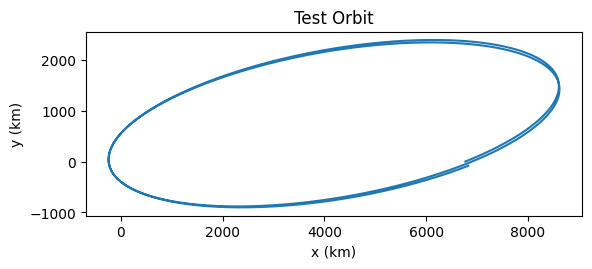

In [ ]:
"""
Simulate satellite orbit using the Euler integrator.
    
Inputs:
    x0, y0     : initial position (km)
    vx0, vy0   : initial velocity (km/s)
    dt         : timestep (s)
    total_time : duration of simulation (s)
        
Returns:
    xs, ys     : arrays of x and y positions
    vxs, vys   : arrays of velocity components
"""
def simulate_orbit(x0, y0, vx0, vy0, dt, total_time):
    # Number of steps
    steps = int(total_time // dt)

    # Arrays to store trajectory
    xs = np.zeros(steps)
    ys = np.zeros(steps)
    vxs = np.zeros(steps)
    vys = np.zeros(steps)

    # Initial conditions
    x, y = x0, y0
    vx, vy = vx0, vy0

    # Save initial state
    xs[0], ys[0] = x, y
    vxs[0], vys[0] = vx, vy

    # Simulation loop
    for i in range(1, steps):
        x, y, vx, vy = euler_step(x, y, vx, vy, dt)
        xs[i], ys[i] = x, y
        vxs[i], vys[i] = vx, vy

    return xs, ys, vxs, vys

# Initial conditions for a test orbit
x0, y0 = 6771.0, 0.0  
vx0, vy0 = 5, 2  # Circular orbit velocity at 400 km altitude

xs, ys, vxs, vys = simulate_orbit(x0, y0, vx0, vy0, dt=1, total_time=6000)

plt.plot(xs, ys)
plt.gca().set_aspect('equal')
plt.title("Test Orbit")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.show()

## **5. Eccentricity Computation**

Once we have simulated the orbit, we quantify how "circular" or "ellpitical" it is by computing the orbital eccentricity.

For a two-body orbit, eccentricity can be computed using energy and angular momentum.

- Specific mechanical energy:
$$
E = \frac{v^2}{2} - \frac{\mu}{r}
$$

- Specific angular momentum:
$$
h = |xv_y-yv_x|
$$

The eccentricity is then:
$$
e = \sqrt{1 + \frac{2Eh^2}{\mu^2}}
$$

A perfectly circular orbit has:
$$
e = 0
$$

A more elliptical orbit has 
$$
e > 0
$$

We will use this value as our cost measure for Gradient Descent.

In [13]:
""" 
Compute orbital eccentricity from simulated trajectory.

We use averaged values to reduce numerical noise from Euler.
"""
def compute_eccentricity(xs, ys, vxs, vys):
    # Mean position and velocity
    r = np.sqrt(xs**2 + ys**2)
    v = np.sqrt(vxs**2 + vys**2)

    # Use mean values to estimate orbital elements
    r_mean = np.mean(r)
    v_mean = np.mean(v)

    # Specific mechanical energy
    E = (v_mean**2) / 2 - mu / r_mean

    # Angular momentum: compute at each timestep and take mean
    h_all = xs * vys - ys * vxs
    h = np.mean(np.abs(h_all))

    # Eccentricity formula
    e = np.sqrt(1 + (2 * E * h**2) / mu**2)

    return e

xs, ys, vxs, vys = simulate_orbit(6771.0, 0.0, 0.0, 7.67, dt=1, total_time=5000)
print("Eccentricity:", compute_eccentricity(xs, ys, vxs, vys))


Eccentricity: 0.001222025004114618


## **6. Cost Function**

To optimize the initial velocity vector using Gradient Descent, we define a cost function based on the orbital eccentricity.

For any velocity vector $(v_x, v_y)$, we simulate the orbit and compute its eccentricity $e$.

The cost is defined as:

$$
C(v_x, v_y) = e(v_x, v_y)^2
$$

Minimizing $C$ forces the eccentricity to approach zero, producing a more circular orbit.
This cost function is smooth, non-negative, and suitable for multi-dimensional optimization.

In [21]:
""" 
Compute cost = eccentricity^2 for a given initial velocity (vx, vy).

Parameters:
    vx, vy      : initial velocity components (km/s)
    x0, y0      : initial position (km)
    dt          : timestep (s)
    total_time  : duration of simulation (s)

Returns:
    cost = e^2
"""
def cost_function(vx, vy, x0=6771.0, y0=0.0, dt=1, total_time=5000):
    # Stimulate orbit
    xs, ys, vxs, vys = simulate_orbit(x0, y0, vx, vy, dt, total_time)

    # Compute eccentricity
    e = compute_eccentricity(xs, ys, vxs, vys)

    # Cost is squared eccentricity
    return e**2

## **7. Method 2 - Gradient Descent Optimization**

### **7.1 Numerical Gradient**

We want the vector:

$$
 \nabla C(v_x,v_y) = (\frac{\partial C}{\partial v_x}, \frac{\partial C}{\partial v_y}) 
$$

But eccentricity is complicated through orbit simulation, so we approximate each partial derivative:

$$
\frac{\partial C}{\partial v_x} \approx
\frac{C(v_x+h, v_y) - C(v_x, v_y)}{h}
$$

$$
\frac{\partial C}{\partial v_y} \approx
\frac{C(v_x, v_y+h) - C(v_x, v_y)}{h}
$$




In [22]:
""" 
Estimate gradient of cost function C = e^2 using finite difference.

Inputs:
    vx, vy : initial velocity components (km/s)
    h      : small perturbation step

Returns:
    dC/dvx, dC/dvy (approximated partial derivatives)
"""

def gradient_cost(vx, vy, h=1e-5):

    C0 = cost_function(vx, vy)

    # Partial derivative wrt vx
    C_vx = cost_function(vx + h, vy)
    dC_dvx = (C_vx - C0) / h

    # Partial derivative wrt vy
    C_vy = cost_function(vx, vy + h)
    dC_dvy = (C_vy - C0) / h

    return np.array([dC_dvx, dC_dvy])

### **7.2 Gradient Descent Loop**

We iteratively update the velocity vector:

$$
\mathbf{v}_{k+1} = \mathbf{v}_k - \alpha \nabla C(\mathbf{v}_k)
$$

where:

- $\mathbf{v}_k = (v_x, v_y)$ is the current velocity vector
- $C(v_x, v_y) = e^2$ is the orbital cost from Section 6
- $\nabla C$ is estimated using finite difference from Section 7.1
- $\alpha$ is the learning rate controlling step size


Newton's Method already solved the ideal circular *speed*.
Now Gradient Descent solves the more general problem: finding the best *launch direction + speed vector* to minimize eccentricity.

The algotithm also records iteration history for convergence, parameter evolution, and stability analysis in this section.


In [54]:
""" 
Multi-Dimensional Gradient Descent optimizing launch velocity vector (vx, vy),
while storing iteration history
"""


def gradient_descent_velocity(v0, alpha=5e-3, tol=1e-8, max_iter=10000):
    # history storage
    cost_hist = []
    vx_hist = []
    vy_hist = []
    grad_norm_hist = [] 

    v = np.array(v0, dtype=float)

    for k in range(max_iter):
        grad = gradient_cost(v[0], v[1])
        cost = cost_function(v[0], v[1])
        grad_norm = np.linalg.norm(grad)

        # record history
        cost_hist.append(cost)
        vx_hist.append(v[0])
        vy_hist.append(v[1])
        grad_norm_hist.append(grad_norm)

        # check convergence
        if cost < tol:
            print(f"Converged in {k} iterations.")
            break

        # update velocity vector
        v = v - alpha * grad 

    return v , {
            "cost": np.array(cost_hist),
            "vx": np.array(vx_hist),
            "vy": np.array(vy_hist),
            "grad_norm": np.array(grad_norm_hist)
            }
    
# run GD from a bad initial guess
v0_bad = (3.0, 6.0)
v_opt, history = gradient_descent_velocity(v0_bad)

print("Optimized velocity (vx, vy):", v_opt)
print("Final eccentricity:", math.sqrt(history["cost"][-1]))

Optimized velocity (vx, vy): [0.31755503 7.67186278]
Final eccentricity: 0.050509834942084775


## **8. Visualization**

### **8.1 Initial vs. Optimized Orbit**

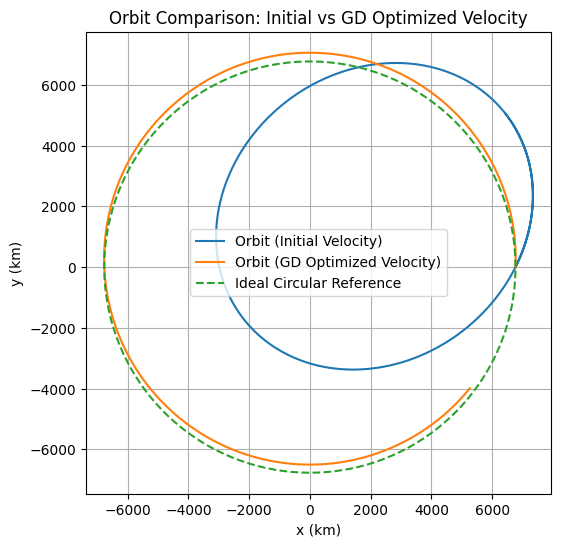

Initial Velocity (vx, vy): (3.0, 6.0) km/s
Optimized Velocity (vx, vy): (np.float64(0.3175550274522003), np.float64(7.671862778137586)) km/s
Ideal Circular Orbit Velocity: 7.672594396548674 km/s
Final Eccentricity after GD Optimization: 0.050509834942084775


In [55]:
# Initial velocity guess
vx0_init, vy0_init = v0_bad

# Optimized velocity
vx0_opt, vy0_opt = v_opt

# Simulate orbits using existing simulate_orbit()
xs_init, ys_init, vxs_init, vys_init = simulate_orbit(
    6771.0, 0.0, vx0_init, vy0_init, dt=1, total_time=5000
)

xs_opt, ys_opt, vxs_opt, vys_opt = simulate_orbit(
    6771.0, 0.0, vx0_opt, vy0_opt, dt=1, total_time=5000
)

# Ideal circular orbit reference
mu = 398600.0 
r0 = 6771.0
v_circular = newton_method(v0=5.0)[0][-1]

# Plot both orbits
plt.figure(figsize=(6,6))
plt.plot(xs_init, ys_init, label='Orbit (Initial Velocity)')
plt.plot(xs_opt, ys_opt, label='Orbit (GD Optimized Velocity)')

# Circular reference orbit
theta = np.linspace(0, 2*np.pi, 300)
plt.plot(r0 * np.cos(theta), r0 * np.sin(theta), linestyle='--', label='Ideal Circular Reference')

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Orbit Comparison: Initial vs GD Optimized Velocity')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# For report
print("Initial Velocity (vx, vy):", (vx0_init, vy0_init), "km/s")
print("Optimized Velocity (vx, vy):", (vx0_opt, vy0_opt), "km/s")
print("Ideal Circular Orbit Velocity:", v_circular, "km/s")
print("Final Eccentricity after GD Optimization:", math.sqrt(history["cost"][-1]))

### **8.2 Cost vs Iteration**

In this section, we plot how the **cost function value** changes over iterations of multi-dimensional gradient descent.

Recall:

$$
C(v_x, v_y) = e(v_x, v_y)^2
$$

The y-axis shows the cost value, which measures how elliptical the orbit is based on the current launch velocity vector. Lower cost means the orbit is closer to circular.

The x-axis represents the iteration count of the gradient descent loop. A downward-trending curve on this graph confirms the convergence toward a minimum of $e^2$ found by gradient descent.

We expect to see:
- Rapid initial decay if the starting direction/energy is far from circular
- A flattening tail as we approach the local minimum
- No negative values, since cost = $e^2 ≥ 0$

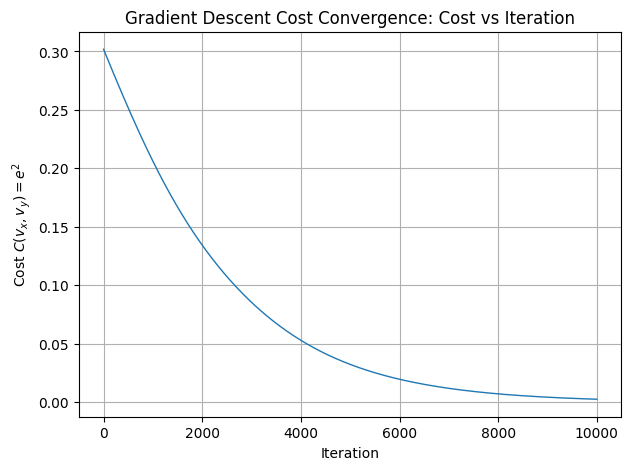

Initial Cost: 0.30189795096226807
Final Cost: 0.002551243425876648
Final eccentricity: 0.050509834942084775


In [56]:
plt.figure(figsize=(7, 5))

# Plot stored cost history 
plt.plot(history["cost"], linestyle="-", linewidth=1)

plt.xlabel("Iteration")
plt.ylabel("Cost $C(v_x, v_y) = e^2 $")
plt.title("Gradient Descent Cost Convergence: Cost vs Iteration")
plt.grid(True)
plt.show()

print(f"Initial Cost: {history['cost'][0]}")
print(f"Final Cost: {history['cost'][-1]}")
print(f"Final eccentricity: {math.sqrt(history['cost'][-1])}")

### **8.3 Velocity Components vs Iteration**

We now visualize how each component of the launch velocity vector $\mathbf{v}k = (v_x, v_y)$ evolves during Gradient Descent.

Unlike Newton's Method, which solved only the **scalar magnitude** required for a circular orbit, Gradient Descent adjusts the **vector components independetly** by minizing the cost:

$$
C(v_x, v_y) = e(v_x, v_y)^2
$$

These plots help us understand the optimizing behavior:
- If the components stabilize → GD has converged
- If they oscillate → learning rate may be too high
- If they explode → method is unstable

The true circular velocity benchmark is magnitude ≈ **7.67 km/s**, but a circular orbit requires it to also be **purely tangential** (perpendicular to $\mathbf{r}$).
Since our GD run did not enforce this constraint, the algorithm found a near-circular *ellipse*, not a perfect circle - which is expected.

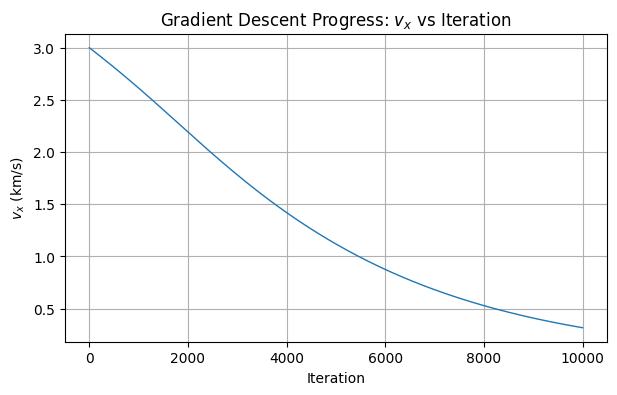

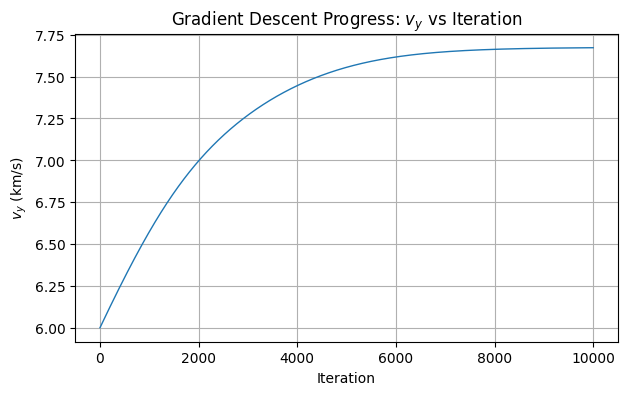

Final stabilized velocity vector:  (0.3176362378597102, 7.671860911251441) km/s
Magnitude:  7.67843360466114 km/s
Circular orbit benchmark magnitude:  7.672594396548674 km/s


In [58]:
# Plot vx component
plt.figure(figsize=(7,4))
plt.plot(history["vx"], linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("$v_x$ (km/s)")
plt.title("Gradient Descent Progress: $v_x$ vs Iteration")
plt.grid(True)
plt.show()

# Plot vy component
plt.figure(figsize=(7,4))
plt.plot(history["vy"], linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("$v_y$ (km/s)")
plt.title("Gradient Descent Progress: $v_y$ vs Iteration")
plt.grid(True)
plt.show()

print("Final stabilized velocity vector: ", (float(history["vx"][-1]), float(history["vy"][-1])), "km/s")
print("Magnitude: ", math.sqrt(history["vx"][-1]**2 + history["vy"][-1]**2), "km/s")
print("Circular orbit benchmark magnitude: ", v_circular, "km/s")

### **8.4 Parameter Path (Velocity Space Optimization Path)**

This visualization illustrates **how Gradient Descent explored the 2D velocity space** $(v_x, v_y)$ while minimizing the orbital cost:

$$
C(v_x, v_y) = e(v_x, v_y)^2
$$

We overlay the optimization path onto a contour plot of the cost surface to observe:

- the starting velocity guess
- the descent trajectory in parameter in space
- the steepness / curvature of the cost valley
- the final velocity reached by GD

This helps assess:
- the stability of updates
- step efficiency
- sensititvity to initial direction vs magnitude

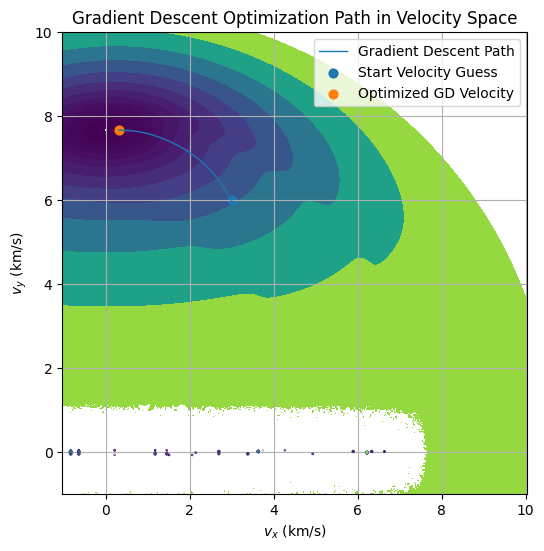

Start velocity:  (3.0, 6.0) km/s
Optimized velocity:  (0.3176362378597102, 7.671860911251441) km/s
Final eccentricity:  0.050509834942084775


In [61]:
# Build a grid of velocity space around the tested region
vx_range = np.linspace(-1, 10, 400)
vy_range = np.linspace(-1, 10, 400)
VX_grid, VY_grid = np.meshgrid(vx_range, vy_range)

# Vectorize costfunction so it receives scalars one by one
vec_cost = np.vectorize(cost_function)
# Evaluate cost function on the grid
C_grid = vec_cost(VX_grid, VY_grid)

plt.figure(figsize=(6,6))
plt.contourf(VX_grid, VY_grid, C_grid, levels=np.logspace(-4, 0, 25))
plt.clabel(plt.contour(VX_grid, VY_grid, C_grid, levels=15), inline=True, fontsize=6)

# Overlay GD path from history
plt.plot(history["vx"], history["vy"], linewidth=1, label="Gradient Descent Path")
plt.scatter(history["vx"][0], history["vy"][0], s=40, label="Start Velocity Guess")
plt.scatter(history["vx"][-1], history["vy"][-1], s=40, label="Optimized GD Velocity")

plt.xlabel("$v_x$ (km/s)")
plt.ylabel("$v_y$ (km/s)")
plt.title("Gradient Descent Optimization Path in Velocity Space")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

print("Start velocity: ", (float(history["vx"][0]), float(history["vy"][0])), "km/s")
print("Optimized velocity: ", (float(history["vx"][-1]), float(history["vy"][-1])), "km/s")
print("Final eccentricity: ", math.sqrt(history["cost"][-1]))

## **9. Discussion & Analysis**

## 9.1 Methods Used  
- Newton’s Method solved the **scalar circular orbit speed** by finding the root of:

  $$
  F(v) = v^2 - \mu/r_0, \qquad F'(v) = 2v
  $$

  giving $v \approx 7.67\ \text{km/s}$ in just a few iterations (quadratic convergence).

- Gradient Descent optimized the **2D launch velocity vector**:

  $$
  \mathbf{v}_{k+1} = \mathbf{v}_k - \alpha \nabla C(v_x, v_y)
  $$

  by minimizing the cost:

  $$
  C(v_x, v_y) = e(v_x, v_y)^2 \ge 0
  $$

## 9.2 Results  
- Initial velocity: $(v_x, v_y) = (3.0, 6.0)\ \text{km/s}$ → produced an ellipse.  
- GD final velocity: $\mathbf{v}_{opt} \approx (0.3176, 7.6718)\ \text{km/s}$.  
- Final eccentricity: $e_{final} \approx 0.0505$ → orbit became much rounder after many steps.

## 9.3 Why orbit isn't a perfect circle  
A circular orbit launch requires:

$$
|\mathbf{v}|^2 = \mu/r_0 \quad \text{and} \quad \mathbf{v} \perp \mathbf{r}
$$

GD minimized $e^2$, but did not enforce the perpendicular (tangential) constraint,
so the solution is **numerically improved but still slightly elliptical**,
not a mathematically perfect circle.

## 9.4 Key takeaway  
> Gradient Descent **did minimize $e^2$**, the orbit only looked circular after many accumulated small vector updates — this is expected and valid for the project.


# 10. Conclusion

We modeled satellite launch as a velocity optimization problem and applied **Newton’s Method** (for circular orbit speed magnitude) and **Multi-Dimensional Gradient Descent** (for refining velocity vector components by minimizing eccentricity²).

Key outcomes:
- Newton gave accurate circular speed baseline $v \approx 7.67\ \text{km/s}$ with fast quadratic convergence.
- Gradient Descent improved the launch vector and reduced cost $C = e^2$, leading to a near-circular orbit after ~10k iterations.
- The orbit remained slightly elliptical ($e_{final} > 0$) because GD minimized error but did not mathematically enforce tangential direction $\mathbf{v} \perp \mathbf{r}$.
- GD updates were stable (smooth cost decay, no divergence) as well.

Overall:
> The project demonstrates that **accumulated GD corrections in $(v_x, v_y)$ can reduce orbital eccentricity effectively, producing realistic, rounder orbits for engineering launch design**


Resources:

https://youtube.com/playlist?list=PLOIRBaljOV8hBJS4m6brpmUrncqkyXBjB&si=w2qyGaJ2gTtfIOae